# Лабораторная работа №4

Задание и этапы работы:

1. Выделить обучающую и тестовую выборки.
2. Определить наилучшее значение k.
3. Оценить качество прогноза на тестовой выборке с помощью таблицы сопряженности.
4. Выдать процент ошибок, допущенных классификатором на тестовой выборке.

## Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.manifold import MDS

Для воспроизводимости экспериментов

In [3]:
random.seed(42)
np.random.seed(42)

## Загрузка и первичный анализ данных

In [4]:
data_path = 'data'

In [5]:
digits_df = pd.read_csv(f"{data_path}/digit_2.csv", sep=';')
digits_df.sample(10)

,DIGIT,B2,C2,D2,E2,F2,G2,H2
361,zero,ONE,ONE,ONE,ZERO,ONE,ONE,ZERO
73,six,ONE,ZERO,ZERO,ONE,ZERO,ONE,ONE
374,zero,ONE,ONE,ONE,ZERO,ONE,ONE,ONE
155,two,ONE,ZERO,ONE,ONE,ONE,ZERO,ONE
104,three,ONE,ONE,ONE,ONE,ZERO,ONE,ONE
394,eight,ZERO,ONE,ONE,ONE,ONE,ONE,ONE
377,nine,ONE,ONE,ONE,ONE,ZERO,ONE,ONE
124,six,ONE,ONE,ZERO,ONE,ONE,ONE,ONE
68,two,ZERO,ZERO,ONE,ONE,ONE,ZERO,ONE
450,nine,ONE,ONE,ONE,ONE,ZERO,ONE,ONE


Посмотрим на типы данных в датасете

In [6]:
digits_df.dtypes

DIGIT    object
B2       object
C2       object
D2       object
E2       object
F2       object
G2       object
H2       object
dtype: object

Видим, что все переменные являются строковыми, возможно идет речь о категориальных переменных. Проверим это, посмотрев на описательные статистики датасета

In [7]:
digits_df.describe()

,DIGIT,B2,C2,D2,E2,F2,G2,H2
count,500,500,500,500,500,500,500,500
unique,10,2,2,2,2,2,2,2
top,eight,ONE,ONE,ONE,ONE,ZERO,ONE,ONE
freq,58,375,299,363,363,290,416,334


Как видно, датасет содержит 500 записей. Столбец `DIGIT` содержит 10 уникальных значений - классы цифр, которые мы будем предсказывать. Остальные столбцы содержат по 2 уникальных значения - `YES` и `NO`, что говорит нам о возможности категориального кодирования всего датасета для более удобной обработки классифицирующими моделями

Проверим датасет на наличие пропущенных значений

In [8]:
digits_df.isna().sum().to_frame().rename(columns={0: "Пропущено значений"})

,Пропущено значений
DIGIT,0
B2,0
C2,0
D2,0
E2,0
F2,0
G2,0
H2,0


Как видим, пропуски в датасете отсутствуют

Построим гистограмму классовых меток по датасету

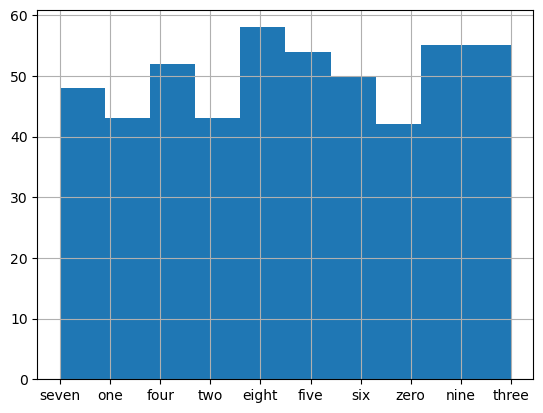

In [9]:
digits_df['DIGIT'].hist()
plt.show()

Из гистограммы видно, что метки достаточно сбалансированы, их распределение не является скошенным (отсутствуют явно выделенные миноритарные или мажоритарные классы), а значит при тренировке классификатора мы можем оптимизировать обычную точность `accuracy`. Однако при оценке качества модели также будем использовать макровзвешенную `F1-меру`  

Заменим категориальные метки `ONE` и `ZERO` на числовые `1` и `0`

In [10]:
digits_df.replace({'ONE': 1, 'ZERO': 0}, inplace=True)
digits_df.sample(10)

,DIGIT,B2,C2,D2,E2,F2,G2,H2
306,one,0,0,1,0,1,1,0
449,seven,1,0,1,0,0,1,1
123,four,0,1,1,1,0,1,1
194,three,1,0,0,1,0,0,1
66,three,1,1,0,0,0,1,1
394,eight,0,1,1,1,1,1,1
430,six,0,1,0,1,1,1,1
345,seven,0,0,1,0,0,1,0
498,zero,1,1,1,0,0,1,0
237,three,1,0,1,1,0,1,1


Посмотрим на точный список классовых меток, чтобы провести их кодирование

In [11]:
digits_df['DIGIT'].unique()

array(['seven', 'one', 'four', 'two', 'eight', 'five', 'six', 'zero',
       'nine', 'three'], dtype=object)

Метки представляют собой словесные названия цифр от 0 до 9 на английском. Заменим их на сами цифры

In [12]:
classes_labels_map = {
    'zero': 0,
    'one': 1,
    'two': 2,
    'three': 3,
    'four': 4,
    'five': 5,
    'six': 6,
    'seven': 7,
    'eight': 8,
    'nine': 9
}

In [13]:
digits_df['DIGIT'] = digits_df['DIGIT'].apply(lambda x: classes_labels_map[x])
digits_df.sample(10)

,DIGIT,B2,C2,D2,E2,F2,G2,H2
115,2,1,0,1,1,1,0,1
267,5,0,1,0,1,0,1,1
27,3,1,0,0,1,0,1,1
421,3,1,0,0,1,0,1,1
471,2,1,0,1,1,1,0,1
257,0,1,1,1,0,1,0,1
469,9,1,1,1,1,0,1,1
459,8,1,1,1,1,1,1,1
455,3,1,0,1,1,0,1,1
435,5,1,1,0,1,0,1,1


Подсчитаем встречаемость каждой цифры

In [14]:
digits_counts = digits_df.DIGIT.value_counts().to_frame()
digits_counts

,count
DIGIT,
8,58
9,55
3,55
5,54
4,52
6,50
7,48
1,43
2,43


Как и было показано на гистограмме - классы имеют достаточно равномерное распределение, разница между количеством появлений самого миноритарного и мажоритарного классов составляет `16` экземпляров, что составляет `3.2%` от размера датасета, поэтому при обучении классификатора будем оптимизировать `accuracy`

## Подготовка данных к обучению классификатора

Выделим независимые переменные и целевую

In [15]:
X = digits_df.drop('DIGIT', axis=1)
y = digits_df.DIGIT

Визуализируем датасет в двумерном пространстве с помощью многомерного шкалирования, чтобы оценить границы выбора значения `k` классификатора

In [16]:
mds = MDS(n_components=2, random_state=42, normalized_stress='auto')
mds_transformed = mds.fit_transform(X)
mds_df = pd.DataFrame(mds_transformed, columns=[f'MDS{i + 1}' for i in range(2)])
mds_df = pd.concat([digits_df, mds_df], axis=1)
mds_df.sample(10)

,DIGIT,B2,C2,D2,E2,F2,G2,H2,MDS1,MDS2
212,3,1,0,1,1,0,1,1,-0.383578,-0.129534
324,8,1,1,1,1,1,1,0,0.038516,-0.118058
298,9,1,1,1,1,0,1,1,0.401549,-0.078584
82,5,1,1,0,1,0,1,1,1.084167,0.081936
442,3,1,0,1,0,0,1,1,-0.901569,-0.266438
314,8,1,1,1,1,0,0,1,-0.230370,0.409457
421,3,1,0,0,1,0,1,1,1.006040,-0.289239
181,3,1,0,1,1,0,1,1,-0.383578,-0.129534
400,9,1,1,1,1,0,1,1,0.401549,-0.078584
42,8,1,1,1,1,1,1,0,0.038516,-0.118058


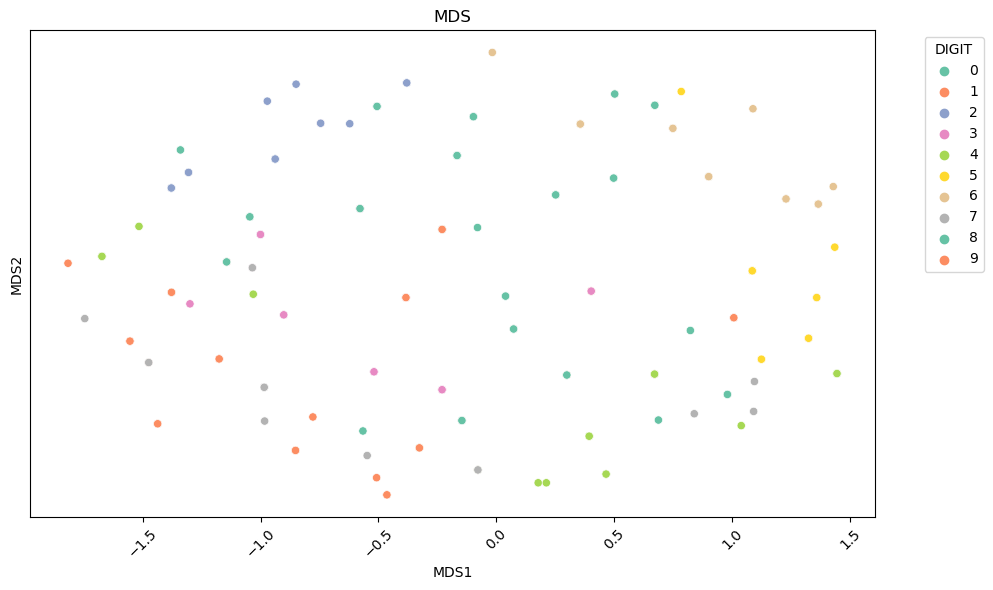

In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=mds_df,
    x='MDS1',
    y='MDS2',
    hue='DIGIT',
    palette='Set2'
)
plt.title('MDS')
plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.yticks([])
plt.xticks(rotation=45)
plt.legend(title='DIGIT', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Как видно, точки разных классов в большинстве своем перемешаны между собой, заметны лишь ленточный кластер нулей и небольшой кластер пятерок. Это может говорить о том, что для качественной классификации нам понадобится достаточно большое значение `k`

Разделим датасет на обучающую и тестовую выборки в соотношении 80/20

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2, shuffle=True)

## Инициализация и обучение kNN классификатора

Создадим экземпляр kNN классификатора с добавленным адаптером, улучшающим качество предсказания вероятностей (может быть полезно для дальнейшего threshold-engineering)

In [19]:
clf = CalibratedClassifierCV(estimator=KNeighborsClassifier()) 

Для подбора наилучшей комбинации параметров классификатора будем использовать поиск по сетке. В качестве оптимизируемых параметров возьмем `n_neighbors` (значение k), `leaf_size` (управление размером классифицирующего дерева при использовании соответствующего алгоритма), `metric` (метрика, которая будет описывать расстояние между объектами) и `weights` - параметр, определяющий будут ли все точки в пространстве иметь одинаковую важность при предсказании класса для нового объекта

In [20]:
parameters = {
    'estimator__n_neighbors': range(1, 50),
    'estimator__leaf_size': range(10, 40, 5),
    'estimator__metric': ['euclidean', 'manhattan', 'hamming', 'cosine', 'minkowski'],
    'estimator__weights': ['distance', 'uniform']
}

При поиске по сетке будем оптимизировать `accuracy` с использованием кросс-валидации с параметром `n` равным 15, что позволит пройтись по датасету большее количество раз. Использование `StratifiedKFold` кросс-валидации поможет сгладить влияние неравномерно распределенных классов (в нашем случае они явно не выделяются, поэтому результат работы будет близок к простой кросс-валидации)

In [21]:
searcher = GridSearchCV(clf, parameters, n_jobs=-1, scoring='accuracy', verbose=5, cv=StratifiedKFold(n_splits=15))
searcher.get_params()

{'cv': StratifiedKFold(n_splits=15, random_state=None, shuffle=False),
 'error_score': nan,
 'estimator__base_estimator': 'deprecated',
 'estimator__cv': None,
 'estimator__ensemble': True,
 'estimator__estimator__algorithm': 'auto',
 'estimator__estimator__leaf_size': 30,
 'estimator__estimator__metric': 'minkowski',
 'estimator__estimator__metric_params': None,
 'estimator__estimator__n_jobs': None,
 'estimator__estimator__n_neighbors': 5,
 'estimator__estimator__p': 2,
 'estimator__estimator__weights': 'uniform',
 'estimator__estimator': KNeighborsClassifier(),
 'estimator__method': 'sigmoid',
 'estimator__n_jobs': None,
 'estimator': CalibratedClassifierCV(estimator=KNeighborsClassifier()),
 'n_jobs': -1,
 'param_grid': {'estimator__n_neighbors': range(1, 50),
  'estimator__leaf_size': range(10, 40, 5),
  'estimator__metric': ['euclidean',
   'manhattan',
   'hamming',
   'cosine',
   'minkowski'],
  'estimator__weights': ['distance', 'uniform']},
 'pre_dispatch': '2*n_jobs',
 'ref

Запустим процесс поиска лучшей комбинации параметров

In [22]:
%%time
searcher.fit(X_train, y_train)
searcher.best_params_

Fitting 15 folds for each of 2940 candidates, totalling 44100 fits
CPU times: total: 1min 28s
Wall time: 20min 23s


{'estimator__leaf_size': 10,
 'estimator__metric': 'euclidean',
 'estimator__n_neighbors': 46,
 'estimator__weights': 'uniform'}

In [23]:
searcher.best_score_

0.7676163342830011

Лучший классификатор выдал точность на обучающей выборке ~77%, интересно заметить, что гипотеза о большом коэффициенте `k` подтвердилась - лучший результат выдал классификатор с k = 46. В качестве метрики расстояния используется евклидово расстояние, все точки пространства имеют одинаковый вес

Сохраним лучший классификатор

In [24]:
best_clf = searcher.best_estimator_
best_clf.get_params()

{'base_estimator': 'deprecated',
 'cv': None,
 'ensemble': True,
 'estimator__algorithm': 'auto',
 'estimator__leaf_size': 10,
 'estimator__metric': 'euclidean',
 'estimator__metric_params': None,
 'estimator__n_jobs': None,
 'estimator__n_neighbors': 46,
 'estimator__p': 2,
 'estimator__weights': 'uniform',
 'estimator': KNeighborsClassifier(leaf_size=10, metric='euclidean', n_neighbors=46),
 'method': 'sigmoid',
 'n_jobs': None}

## Оценка качества работы классификатора

Детальнее рассмотрим поведение классификатора на обучающей выборке

In [25]:
train_pred = best_clf.predict(X_train)
train_pred

array([0, 4, 1, 5, 4, 0, 9, 7, 5, 1, 4, 7, 7, 9, 8, 6, 2, 8, 7, 4, 4, 9,
       4, 2, 8, 4, 2, 2, 3, 9, 9, 8, 3, 5, 1, 5, 2, 4, 3, 9, 9, 0, 0, 3,
       1, 9, 0, 4, 8, 3, 9, 2, 2, 6, 6, 9, 8, 8, 8, 4, 2, 2, 0, 7, 9, 3,
       4, 6, 9, 5, 5, 5, 3, 3, 0, 7, 7, 2, 4, 7, 8, 2, 5, 7, 3, 5, 3, 0,
       4, 5, 6, 5, 3, 2, 8, 7, 5, 0, 7, 6, 6, 3, 5, 4, 2, 5, 5, 4, 1, 0,
       4, 7, 3, 1, 1, 1, 0, 9, 2, 0, 3, 7, 4, 6, 5, 7, 3, 9, 6, 9, 0, 8,
       9, 9, 2, 8, 6, 3, 2, 4, 5, 3, 0, 4, 1, 0, 3, 2, 9, 9, 0, 4, 8, 9,
       3, 5, 6, 8, 2, 2, 4, 1, 3, 3, 0, 9, 7, 6, 8, 9, 8, 2, 0, 0, 6, 3,
       6, 6, 3, 5, 5, 1, 2, 3, 6, 3, 3, 8, 5, 4, 2, 3, 3, 6, 7, 8, 5, 5,
       9, 6, 5, 4, 9, 0, 5, 4, 9, 8, 4, 7, 0, 3, 4, 6, 8, 4, 7, 5, 5, 2,
       8, 9, 4, 1, 1, 5, 7, 5, 5, 8, 8, 6, 4, 8, 9, 8, 6, 3, 3, 1, 0, 1,
       4, 6, 7, 4, 1, 6, 4, 9, 3, 2, 0, 2, 6, 3, 9, 6, 4, 6, 6, 3, 6, 4,
       1, 5, 2, 0, 9, 4, 6, 3, 3, 4, 3, 3, 0, 1, 8, 1, 6, 2, 8, 1, 6, 1,
       1, 9, 7, 6, 2, 4, 8, 6, 1, 6, 1, 3, 4, 6, 0,

In [26]:
train_accuracy = accuracy_score(y_train, train_pred)
print(f"Точность на обучающей выборке составила: {train_accuracy}")

Точность на обучающей выборке составила: 0.7625


In [27]:
train_f1 = f1_score(y_train, train_pred, average='macro')
print(f"Макровзвешенная F1-мера на обучающей выборке составила: {train_f1}")

Макровзвешенная F1-мера на обучающей выборке составила: 0.765027683453182


На обучающей выборке модель показала качество примерно в 77%, что достаточно хороший результат для такого простого классификатора, как kNN

Построим на матрицу ошибок модели на обучающей выборке

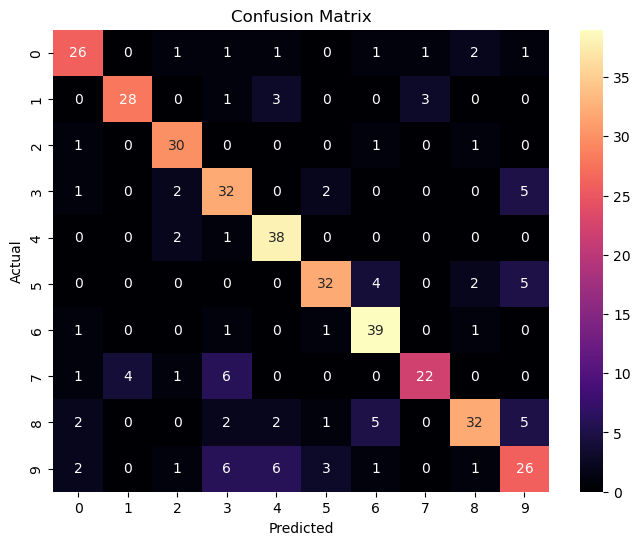

In [28]:
cm = confusion_matrix(y_train, train_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Как видно, чаще всего модель путает цифры 9 и 3 (согласно логике датасета они должны отличаться одним значением), 9 и 4 (аналогично), 7 и 3 (здесь разница между цифрами должна быть сильнее), но глобально качество работы на обучающей выборке достаточно хорошее

Проверим модель на тестовой выборке

In [29]:
pred = best_clf.predict(X_test)
pred

array([9, 1, 6, 5, 4, 4, 3, 8, 5, 7, 4, 3, 3, 7, 6, 2, 3, 7, 0, 3, 7, 5,
       6, 2, 0, 4, 4, 5, 1, 9, 4, 3, 7, 7, 7, 2, 0, 1, 3, 4, 2, 4, 0, 5,
       2, 7, 5, 3, 9, 8, 3, 9, 2, 7, 7, 3, 3, 4, 8, 7, 4, 4, 3, 2, 6, 3,
       3, 4, 5, 6, 8, 6, 4, 7, 2, 9, 3, 0, 4, 0, 3, 5, 7, 1, 2, 0, 3, 1,
       8, 4, 8, 1, 4, 3, 4, 5, 5, 8, 7, 2], dtype=int64)

In [30]:
test_accuracy = accuracy_score(y_test, pred)
print(f"Точность на тестовой выборке составила: {test_accuracy}")

Точность на тестовой выборке составила: 0.82


In [31]:
test_f1 = f1_score(y_test, pred, average='macro')
print(f"Макровзвешенная F1-мера на тестовой выборке составила: {test_f1}")

Макровзвешенная F1-мера на тестовой выборке составила: 0.8219889519083067


На тестовой выборке модель показала качество примерно в 82%, что хороший результат для kNN. Прирост в качестве относительно обучающей выборки может говорит о низкой переобучаемости kNN или удачно выбранной тестовой выборке 

Построим на матрицу ошибок модели на тестовой выборке

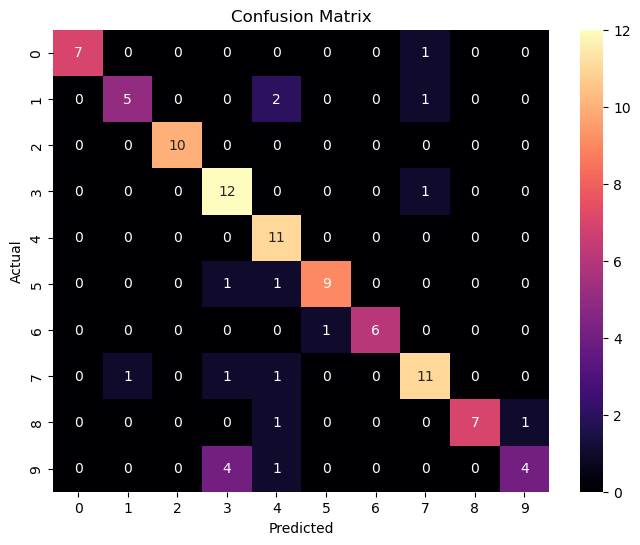

In [32]:
cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Можно заметить, что труднее всего предсказывается цифра 9 (что было характерно и для обучающей выборки), в остальных случаях количество ошибок низкое, что может быть следствием достаточно высокого качества обученного классификатора и небольшого размера датасета и тестовой выборки соответственно